**Assignment - Josh Silverbeck**

*Goal:* to predict adherence to lockdown rules (as measured by a combination of stringency and use of public transport), based off social media posts

In [53]:
# Import packages

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.inspection import permutation_importance
import warnings

In [54]:
warnings.filterwarnings('ignore')

In [55]:
# Load data

# The social media data comes from 10 Kaggle files, saved as jsons

df = pd.read_json('dutch_tweets_chunk0.json.zip')

for i in range(1, 10):
    print('Now processing chunk ' + str(i))

    chunk = pd.read_json('dutch_tweets_chunk' + str(i) + '.json.zip')
    frames = [df, chunk]

    df = pd.concat(frames)

print('Dataframe dimensions: ' + str(df.shape))
df.head()

Now processing chunk 1
Now processing chunk 2
Now processing chunk 3
Now processing chunk 4
Now processing chunk 5
Now processing chunk 6
Now processing chunk 7
Now processing chunk 8
Now processing chunk 9
Dataframe dimensions: (271342, 23)


,full_text,text_translation,created_at,screen_name,description,desc_translation,weekofyear,weekday,day,month,year,location,point_info,point,latitude,longitude,altitude,province,hisco_standard,hisco_code,industry,sentiment_pattern,subjective_pattern
0,"@pflegearzt @Friedelkorn @LAguja44 Pardon, wol...",@pflegearzt @Friedelkorn @ LAguja44 Pardon wol...,2020-03-09 12:26:29,TheoRettich,"I ❤️science, therefore a Commie. ☭ FALGSC: P...","I ❤️science, Therefore a Commie. ☭ FALGSC: Par...",11.0,0.0,9.0,3.0,2020.0,Netherlands,Nederland,"(52.5001698, 5.7480821, 0.0)",52.50017,5.748082,0.0,Flevoland,None,None,False,0.0,0.0
1,RT @grantshapps: Aviation demand is reduced du...,RT @grantshapps: Aviation demand is reduced du...,2020-03-09 12:26:34,davidiwanow,I tweet a lot but love to engage & converse. P...,I tweet a lot but love to engage and converse....,11.0,0.0,9.0,3.0,2020.0,"Amsterdam, The Netherlands","Amsterdam, Noord-Holland, Nederland","(52.3727598, 4.8936041, 0.0)",52.37276,4.893604,0.0,Noord-Holland,None,None,False,0.0,0.0
2,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,2020-03-09 12:26:37,EricL65,None,None,11.0,0.0,9.0,3.0,2020.0,None,None,None,NaN,NaN,0.0,False,None,None,False,0.0,0.0
3,RT @DDStandaard: De droom van D66 wordt werkel...,RT @DDStandaard: The D66 dream come true: COVI...,2020-03-09 12:26:37,EricL65,None,None,11.0,0.0,9.0,3.0,2020.0,None,None,None,NaN,NaN,0.0,False,None,None,False,0.0,0.0
4,De droom van D66 wordt werkelijkheid: COVID-19...,The D66 dream becomes reality: COVID-19 super ...,2020-03-09 12:26:47,EhrErwin,Budget-Life Coach. Time management Coaching. b...,Budget-Life Coach. Time management coaching. h...,11.0,0.0,9.0,3.0,2020.0,Amsterdam,"Amsterdam, Noord-Holland, Nederland","(52.3727598, 4.8936041, 0.0)",52.37276,4.893604,0.0,Noord-Holland,None,None,False,0.0,0.0


In [56]:
# Create column with the day of the tweet in format YYYYMMDD

df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
earliest_date = min(df['date'])
latest_date = max(df['date'])

In [57]:
# The other data is downloaded from Our World In Data

# Mobility data
mobility = pd.read_csv('visitors-transit-covid.csv')
mobility = mobility[mobility['Entity'] == 'Netherlands'] # filter to Netherlands
mobility['Day'] = pd.to_datetime(mobility['Day'])
mobility = mobility[(mobility['Day'] >= earliest_date) & (mobility['Day'] <= latest_date)] # filter to relevant days
print('Mobility dataframe dimensions: ' + str(mobility.shape))
mobility.head()

Mobility dataframe dimensions: (222, 4)


,Entity,Code,Day,transit_stations
78214,Netherlands,NLD,2020-02-17,-1.667
78215,Netherlands,NLD,2020-02-18,-2.000
78216,Netherlands,NLD,2020-02-19,-2.200
78217,Netherlands,NLD,2020-02-20,-2.333
78218,Netherlands,NLD,2020-02-21,-1.857


In [58]:
# The other data is downloaded from Our World In Data

# Mobility data
stringency = pd.read_csv('owid-covid-data.csv')
stringency = stringency[stringency['location'] == 'Netherlands'] # filter to Netherlands
stringency['date'] = pd.to_datetime(stringency['date'])
stringency = stringency[(stringency['date'] >= earliest_date) & (stringency['date'] <= latest_date)] # filter to relevant days
print('Stringency dataframe dimensions: ' + str(stringency.shape))
stringency.head()

Stringency dataframe dimensions: (212, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
151431,NLD,Europe,Netherlands,2020-02-27,1.0,1.0,NaN,NaN,NaN,NaN,0.057,0.057,NaN,NaN,NaN,NaN,NaN,7.0,0.399,1.0,0.057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.944,17564020.0,NaN,NaN,NaN,NaN
151432,NLD,Europe,Netherlands,2020-02-28,6.0,5.0,NaN,NaN,NaN,NaN,0.342,0.285,NaN,NaN,NaN,NaN,NaN,8.0,0.455,9.0,0.512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.944,17564020.0,NaN,NaN,NaN,NaN
151433,NLD,Europe,Netherlands,2020-02-29,10.0,4.0,NaN,NaN,NaN,NaN,0.569,0.228,NaN,NaN,NaN,NaN,NaN,9.0,0.512,10.0,0.569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.944,17564020.0,NaN,NaN,NaN,NaN
151434,NLD,Europe,Netherlands,2020-03-01,18.0,8.0,NaN,NaN,NaN,NaN,1.025,0.455,NaN,NaN,NaN,NaN,NaN,11.0,0.626,20.0,1.139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.944,17564020.0,-2332.1,-7.62,-8.61,-132.77712
151435,NLD,Europe,Netherlands,2020-03-02,24.0,6.0,NaN,NaN,NaN,NaN,1.366,0.342,NaN,NaN,NaN,NaN,NaN,10.0,0.569,34.0,1.936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.944,17564020.0,NaN,NaN,NaN,NaN


The stringency dataframe is missing the first few days of data, so we'll drop these days when merging.

In [59]:
target = mobility[['Day', 'transit_stations']].merge(stringency[['date', 'stringency_index']], left_on = 'Day', right_on = 'date', how = 'inner').drop('Day', axis = 1)
target['stringency_index'] = target['stringency_index']/100 # put on scale of 0 to 1, not 0 to 100
target['transit_stations_scaled'] = (target['transit_stations'] - np.min(target['transit_stations'])) / (np.max(target['transit_stations']) - np.min(target['transit_stations']))/2 + 0.5 # scale mobility between 0 and 1
target['defiance'] = target['stringency_index'] * target['transit_stations_scaled'] # combine the two metrics by multiplying, on the same scale of 0 to 1 (see README)
target.head()

,transit_stations,date,stringency_index,transit_stations_scaled,defiance
0,-1.429,2020-02-27,0.0556,0.992291,0.055171
1,-2.286,2020-02-28,0.0556,0.985684,0.054804
2,-4.143,2020-02-29,0.0556,0.971368,0.054008
3,-4.143,2020-03-01,0.0556,0.971368,0.054008
4,-3.714,2020-03-02,0.0556,0.974675,0.054192


**Visualizing and defining the target**

<AxesSubplot:xlabel='date'>

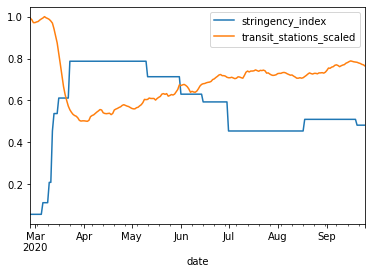

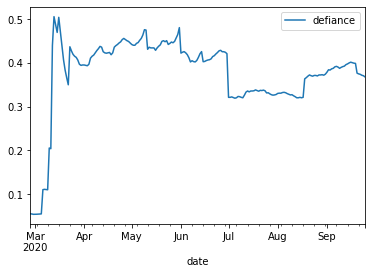

In [60]:
target.plot('date', ['stringency_index', 'transit_stations_scaled'])
target.plot('date', 'defiance')

Initially you get a big jump as people adjust to the new situation. This is a different period of behaviour to later in the pandemic, so let's start on the 13th March, when the first government measures to restrict in-person meetings were announced.

<AxesSubplot:xlabel='date'>

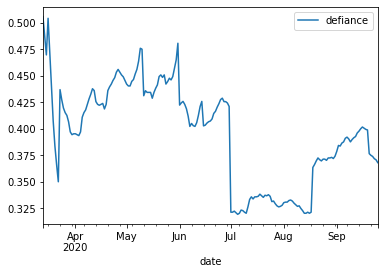

In [61]:
target = target[target['date'] >= '2020-03-13']
target.plot('date', 'defiance')

In [62]:
# How can we spot when there is a spike? Compare the average of the defiance over the next 3 days to the current day (as a ratio) - if the ratio is high then there will be a sustained spike over the next 3 days

target['defiance_change'] = pd.Series(target['defiance']).rolling(window = 3, min_periods = 1).mean().shift(-3) / target['defiance']

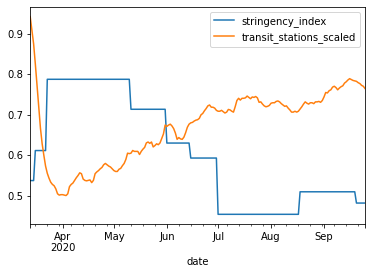

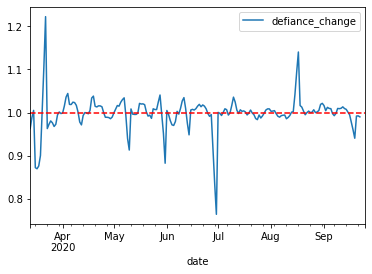

In [63]:
target.plot('date', ['stringency_index', 'transit_stations_scaled'])
target.plot('date', 'defiance_change')
plt.axhline(y = 1, color = 'r', linestyle = '--')

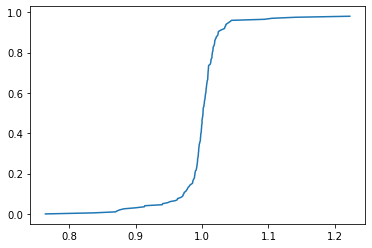

In [64]:
# cdf of defiance_change
def cdf(x, plot=True, *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return plt.plot(x, y, *args, **kwargs) if plot else (x, y)

cdf(target['defiance_change']) # to understand distribution of change

In [65]:
sum(target['defiance_change'] >= 1)/target.shape[0] # % of days with defiance increasing on average in the next week - nicely balanced

0.5329949238578681

**Understanding Kaggle data set**

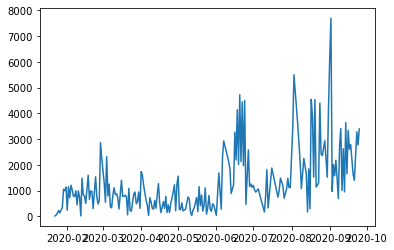

In [66]:
# Number of posts over time

plt.plot(df[['date', 'full_text']].groupby('date').agg('count'))

In [67]:
# What are the posts about? Relevant topics include covid and travel words

covid_key_words = ['covid', 'corona', 'virus', 'lockdown', 'pcr', 'cases', 'deaths', 'vaccine']
travel_key_words = ['train', 'bus', 'car', 'tram', 'meet', 'journey', 'transport', 'drive']

In [68]:
# Clean text of tweets to lower-case, remove punctuation (including e.g. COVID-19 to covid 19)

df['text_translation_clean'] = df['text_translation'].str.replace('[^\w\s]',' ') # remove punctuation (may introduce double spaces but that doesn't matter for now)
df['text_translation_clean'] = df['text_translation_clean'].str.lower()

In [69]:
df['covid'] = df['text_translation_clean'].astype(str).apply(lambda x: any([k in x for k in covid_key_words]))
df['travel'] = df['text_translation_clean'].astype(str).apply(lambda x: any([k in x for k in travel_key_words]))

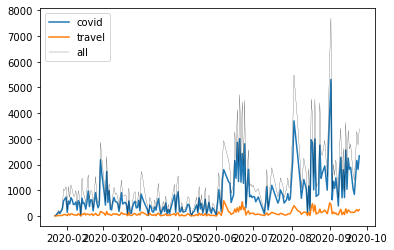

In [70]:
plt.plot(df[df['covid']][['date', 'full_text']].groupby('date').agg('count'), label = 'covid')
plt.plot(df[df['travel']][['date', 'full_text']].groupby('date').agg('count'), label = 'travel')
plt.plot(df[['date', 'full_text']].groupby('date').agg('count'), linewidth = 0.2, color = 'black', label = 'all')
plt.legend()

In [71]:
# Most posts are about covid, a few are about travel:
print('% of posts about Covid: ' + str(round(100 * sum(df['covid'])/df.shape[0], 0)) + '%')
print('% of posts about Travel: ' + str(round(100 * sum(df['travel'])/df.shape[0], 0)) + '%')

% of posts about Covid: 64.0%
% of posts about Travel: 8.0%


**Feature Engineering**

In [72]:
# Daily volumes of posts, split by category

daily_df = df.groupby(['date', 'weekday']).agg({'full_text': 'count',
                                                'covid': 'sum',
                                                'travel': 'sum',
                                                })\
    .reset_index().rename(columns = {'full_text':'posts'})

# We have to normalise covid and travel by the total number of posts, since this changes each day
daily_df['covid'] = daily_df['covid'] / daily_df['posts']
daily_df['travel'] = daily_df['travel'] / daily_df['posts']

In [73]:
# Volumes from the previous week, again split by category

daily_df['weekly_covid'] = pd.Series(daily_df['covid']).rolling(window = 7, min_periods = 1).sum()
daily_df['weekly_travel'] = pd.Series(daily_df['travel']).rolling(window = 7, min_periods = 1).sum()

In [74]:
# Daily trends: day-on-day change

daily_df['covid_dod'] = daily_df['covid']/daily_df['covid'].shift(1)
daily_df['travel_dod'] = daily_df['travel']/daily_df['travel'].shift(1)

In [75]:
# Weekly trends: weekly_posts / (weekly_posts 7 days ago)

daily_df['covid_wow'] = daily_df['weekly_covid']/daily_df['weekly_covid'].shift(7)
daily_df['travel_wow'] = daily_df['weekly_travel']/daily_df['weekly_travel'].shift(7)

In [76]:
# Seasonality: dummy variable for the weekend

daily_df[['date', 'weekday']].head() # 22nd Jan 2020 was a Wednesday and weekday = 2, so weekend is weekday = 5 or 6
daily_df['weekend'] = daily_df['weekday'].apply(lambda x: (x == 5) or (x == 6))

In [77]:
# Sentiment / subjectivity

sentiment_df = df.assign(covid_sentiment = df['covid'] * df['sentiment_pattern'],
                         covid_subjectivity = df['covid'] * df['subjective_pattern'])\
    .groupby('date').agg({'covid_sentiment': ['mean', 'std'],
                          'covid_subjectivity': ['mean']})\
    .reset_index()
sentiment_df.columns = ['date', 'covid_sentiment_mean', 'covid_sentiment_std', 'covid_subjectivity_mean']

daily_df = daily_df.merge(sentiment_df, on = 'date', how = 'inner')

In [78]:
# Covid case and death numbers (also from Our World In Data)

daily_df = daily_df.merge(stringency[['date', 'new_cases', 'new_deaths']], on = 'date', how = 'inner')

In [79]:
# Add target

target['y'] = target['defiance_change'] > 1
daily_df = daily_df.merge(target[['date', 'y']], on = 'date', how = 'inner')
daily_df.head()

,date,weekday,posts,covid,travel,weekly_covid,weekly_travel,covid_dod,travel_dod,covid_wow,travel_wow,weekend,covid_sentiment_mean,covid_sentiment_std,covid_subjectivity_mean,new_cases,new_deaths,y
0,2020-03-13,4.0,723,0.665284,0.065007,4.682885,0.558237,1.061314,0.696842,0.908342,1.233544,False,0.034307,0.224276,0.255620,155.0,5.0,False
1,2020-03-14,5.0,285,0.614035,0.084211,4.605231,0.551295,0.922968,1.295409,0.905717,1.140750,True,0.044122,0.216816,0.247249,176.0,2.0,False
2,2020-03-15,6.0,843,0.581257,0.066429,4.474367,0.548027,0.946619,0.788849,0.884091,1.127059,True,0.042261,0.195810,0.243667,278.0,8.0,True
3,2020-03-16,0.0,1401,0.645253,0.097787,4.439273,0.551287,1.110099,1.472048,0.879069,1.087998,False,0.050879,0.231782,0.261242,292.0,4.0,False
4,2020-03-17,1.0,778,0.595116,0.105398,4.386590,0.579417,0.922298,1.077834,0.890039,1.080300,False,0.032948,0.216989,0.257675,346.0,19.0,False


In [80]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 159
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     160 non-null    datetime64[ns]
 1   weekday                  160 non-null    float64       
 2   posts                    160 non-null    int64         
 3   covid                    160 non-null    float64       
 4   travel                   160 non-null    float64       
 5   weekly_covid             160 non-null    float64       
 6   weekly_travel            160 non-null    float64       
 7   covid_dod                160 non-null    float64       
 8   travel_dod               160 non-null    float64       
 9   covid_wow                160 non-null    float64       
 10  travel_wow               160 non-null    float64       
 11  weekend                  160 non-null    bool          
 12  covid_sentiment_mean     160 non-nul

In [81]:
daily_df.describe()

,weekday,posts,covid,travel,weekly_covid,weekly_travel,covid_dod,travel_dod,covid_wow,travel_wow,covid_sentiment_mean,covid_sentiment_std,covid_subjectivity_mean,new_cases,new_deaths
count,160.000000,160.00000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,159.000000
mean,3.006250,1435.67500,0.623013,0.077434,4.361114,0.542842,1.008766,inf,0.999436,1.013398,0.025857,0.214323,0.246993,586.650000,36.031447
std,2.001562,1343.71378,0.063572,0.025070,0.259051,0.078545,0.131053,NaN,0.064800,0.174249,0.014386,0.022716,0.035530,546.788488,52.009057
min,0.000000,30.00000,0.366667,0.000000,3.706208,0.402456,0.609901,0.000000,0.849898,0.711278,-0.014139,0.135657,0.107717,36.000000,0.000000
25%,1.000000,481.00000,0.591517,0.063842,4.152592,0.481008,0.937362,0.809460,0.946029,0.865508,0.017963,0.204570,0.231343,175.000000,2.000000
50%,3.000000,1043.50000,0.634456,0.076725,4.421629,0.526232,0.994464,0.963963,1.005870,0.976750,0.025314,0.216213,0.248378,476.500000,8.000000
75%,5.000000,1897.00000,0.669215,0.089390,4.576191,0.601529,1.066640,1.200588,1.043062,1.146490,0.034755,0.225746,0.266594,846.750000,53.000000
max,6.000000,7694.00000,0.750789,0.202255,4.841075,0.728364,1.670455,inf,1.140006,1.511128,0.069643,0.281284,0.342539,2779.000000,234.000000


Took inner merges to ensure no NAs, but there is still one row with no deaths, and one with inf travel_dod (since previous day had zero travel)

In [82]:
daily_df['new_deaths'].fillna(0, inplace = True) # fill with 0
daily_df.replace(np.inf, np.ma.masked_invalid(daily_df['travel_wow']).mean(), inplace = True) # fill with mean of rest of column

**Train/test split**

When analysing features, only want to use the train set, so split here.

Not enough data to use a validation set (see READ ME).

In [84]:
train_rows = np.floor(daily_df.shape[0] * 0.75)
test_rows = daily_df.shape[0] - train_rows

daily_df['train_test'] = ['train'] * int(train_rows) + ['test'] * int(test_rows)

**Feature Analysis**

In [85]:
analysis_df = daily_df[daily_df['train_test'] == 'train'].drop(['date', 'weekday', 'posts', 'train_test'], axis = 1) # posts and weekday aren't features we will use

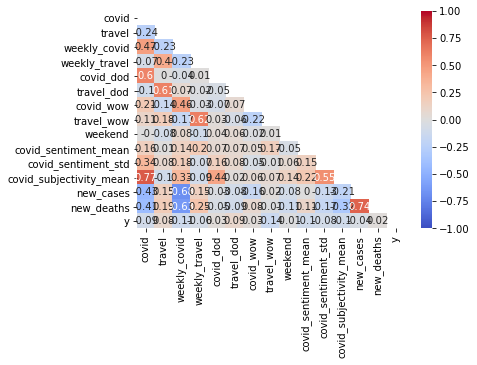

In [86]:
# Feature correlation heatmap:

plt.rcParams['axes.facecolor'] = 'white'

corr_matrix = analysis_df.corr(method = 'spearman').round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
sns.heatmap(corr_matrix, annot = True, vmax = 1, vmin = -1, center = 0, cmap = 'coolwarm', mask = mask)
plt.show()

In [87]:
# Change feature selected here to analyse different features

feature = 'new_deaths'

In [88]:
sorted_mat = corr_matrix.unstack().sort_values(ascending = False)
sorted_df = pd.DataFrame(sorted_mat).reset_index()
sorted_df[(sorted_df['level_0'] == feature) & (sorted_df['level_1'] != feature)] # correlated features

,level_0,level_1,0
18,new_deaths,new_cases,0.74
40,new_deaths,weekly_travel,0.25
47,new_deaths,travel,0.19
72,new_deaths,covid_sentiment_mean,0.11
80,new_deaths,covid_wow,0.08
111,new_deaths,y,0.02
133,new_deaths,travel_wow,-0.01
150,new_deaths,covid_dod,-0.05
174,new_deaths,travel_dod,-0.09
190,new_deaths,weekend,-0.11


<AxesSubplot:xlabel='y', ylabel='new_deaths'>

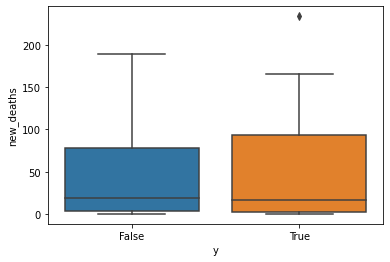

In [89]:
# View distribution by y:

sns.boxplot(x = 'y', y = feature, data = analysis_df)

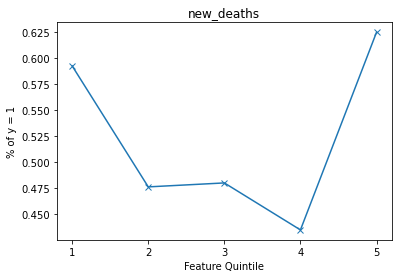

In [90]:
# Group feature values and summarise target for each:

cuts = 5

df_ntile = analysis_df[[feature, 'y']]
df_ntile['ntile'] = pd.qcut(df_ntile[feature], q = cuts, labels = range(1, cuts + 1)) # split into tiles by group

df_ntile = df_ntile.groupby('ntile').agg({'y': np.mean}).reset_index()
plt.plot([x for x in range(1,(cuts+1))], df_ntile['y'], linestyle = 'solid', marker = 'x')
plt.xticks(np.arange(1, cuts + 1, 1.0))
plt.title(feature)
plt.xlabel('Feature Quintile')
plt.ylabel('% of y = 1')
plt.show()

**Feature Selection**

In [91]:
daily_df['weekend'] = np.where(daily_df['weekend'], 1, 0) # for xgboost model

In [92]:
# Comment in/out lines to include features in the model
# Features are based off analysis, but adjusted to reduce overfit / depending on feature importance in the model

features = [
    'covid',
    'travel',

    # 'weekly_covid',
    # 'weekly_travel',

    # 'covid_dod',
    # 'travel_dod',

    # 'covid_wow',
    'travel_wow',

    # 'weekend',

    # 'covid_sentiment_mean',
    # 'covid_sentiment_std',
    # 'covid_subjectivity_mean',

    # 'new_cases',
    'new_deaths'
]

**Modelling**

In [93]:
# Split features and target

X = daily_df[features]
y = daily_df['y']

In [94]:
# Split into train and test

X_train, X_test = X[daily_df['train_test'] == 'train'], X[daily_df['train_test'] == 'test']
y_train, y_test = y[daily_df['train_test'] == 'train'], y[daily_df['train_test'] == 'test']

In [95]:
# Fit model

# Parameters are based off grid search, but adjusted to reduce overfit
np.random.seed(123)

model = KNeighborsClassifier()
model.fit(X = X_train, y = y_train)

y_pred = model.predict(X_test)
y_pred

array([ True, False,  True,  True, False, False, False, False,  True,
       False, False,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True, False,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True, False, False, False])

In [96]:
y_pred_train = model.predict(X_train)

confusion_matrix_train = metrics.confusion_matrix(y_train, y_pred_train)

print('Train:')
print(confusion_matrix_train)
print('Accuracy = ' + str(round(100 * metrics.accuracy_score(y_train, y_pred_train), 1)) + '%')
print('Recall = ' + str(round(100 * metrics.recall_score(y_train, y_pred_train), 1)) + '%')
print('Precision = ' + str(round(100 * metrics.precision_score(y_train, y_pred_train), 1)) + '%')

Train:
[[39 18]
 [16 47]]
Accuracy = 71.7%
Recall = 74.6%
Precision = 72.3%


In [97]:
confusion_matrix_test = metrics.confusion_matrix(y_test, y_pred)

print('Test:')
print(confusion_matrix_test)
print('\nAccuracy = ' + str(round(100 * metrics.accuracy_score(y_test, y_pred), 1)) + '%')
print('\nRecall = ' + str(round(100 * metrics.recall_score(y_test, y_pred), 1)) + '%')
print('\nPrecision = ' + str(round(100 * metrics.precision_score(y_test, y_pred), 1)) + '%')

Test:
[[ 6  8]
 [11 15]]

Accuracy = 52.5%

Recall = 57.7%

Precision = 65.2%


**Feature Importance**

Can also be used for feature selection

Text(0.5, 1.0, 'feature importance')

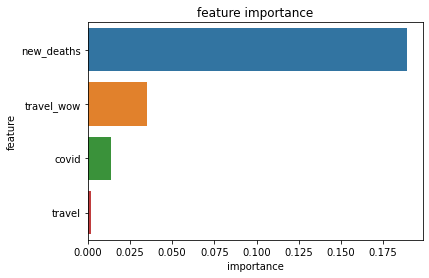

In [98]:
feature_importance = permutation_importance(model, X_train, y_train, n_repeats = 20, random_state = 123).importances_mean
feature_importance_df = pd.DataFrame({'feature': features,
                                      'importance': feature_importance})\
    .sort_values('importance', ascending = False)

sns.barplot(x = 'importance', y = 'feature', data = feature_importance_df).set_title('feature importance')